### Remove Unwanted Runtime Warnings and Import Neccessary Libraries

In [10]:
import warnings
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore') # Removes the warnings about deprecated features and such 

### Preprocessing Image Labels and Aggregating Data

This cell performs the following steps on an Excel file containing image labels:
1. **Read the ImageLabels Excel file** The current working directory is `Example Data-20240208T214429Z-001\Example Data\ImageLabels.xlsx` using `pandas`, selecting only the columns `Image Name`, `Confidence`, `Instance Count`, and `Label`. 

2. **Filter the data** to include only rows where the `Confidence` is at least 80% and the `Instance Count` is greater than 0.

3. **Modify the `Label` column** to append the `Instance Count` before the label (e.g., if there is 1 instance of "Human", it becomes "1 Human").

4. **Group the data by `Image Name`** and aggregates the labels into a list for each image.

5. **Rename the `Label` column to `Labels`** to accurately reflect that it now contains a list of labels.

6. **Display the top entries** of the aggregated dataframe to provide a preview of the data.


In [11]:
BASE_DIR = 'Example Data-20240208T214429Z-001/Example Data/'

df = pd.read_excel(f'{BASE_DIR}/ImageLabels.xlsx', usecols=['Image Name', 'Confidence', 'Instance Count', 'Label'])

# Append the instance counts >=1 to the label, e.g: '1 Human'

# Filter based on the criteria
filtered_df = df[(df['Confidence'] >= 70)]

# Append the instance counts to the label, e.g: '1 Human'
filtered_df['Labels'] = filtered_df['Instance Count'].astype(str) + ' ' + filtered_df['Label']

# Aggregate labels for each image
aggregated_labels = filtered_df.groupby('Image Name')['Labels'].apply(lambda x: ', '.join(x)).reset_index()

# Display the aggregated dataframe
aggregated_labels.head()

,Image Name,Labels
0,(1) 18380579401063495.JPG,1 Motor Bike
1,(1) @GreyCupFestival - 109th Grey Cup.jpeg,"2 Adult, 1 Female, 7 Person, 1 Woman, 1 Male, ..."
2,(10) 17887803224903630.jpeg,"0 Animal, 1 Horse, 0 Horseback Riding, 0 Leisu..."
3,(12) 17985809330117499.jpeg,"0 Fun, 0 Vacation, 1 Person, 0 Road Trip, 1 He..."
4,(13) 18013990822817757.jpeg,"0 Clothing, 0 Coat, 0 Jacket, 0 Vest, 0 Shirt,..."


### Creating a Dictionary of Image Labels

This cell converts the aggregated data frame into a dictionary where each key is an `Image Name` and each value is a list of associated `Labels`. This structure facilitates easier access and manipulation of the labels associated with each image. This is followed by displaying the first five entries of the dictionary to verify its structure and contents.


In [12]:
labels_dict = aggregated_labels.set_index('Image Name').to_dict()['Labels']

# Show the first few elements of the dictionary to verify
list(labels_dict.items())[:5]

# Extract the name of all the images in the folder into a list
image_names = aggregated_labels['Image Name'].tolist()

### Vectorizing Text Data

We now begin to prepare and vectorize the text data for analysis, using the following steps:

1. **Assume variables** `user_text_prompt` and `smart_story_descriptions` contain user inputs.

2. **Prepare the data** by combining these texts with the image labels, which have been converted into semicolon-separated strings.



In [13]:
# Initialize user_text_prompt and smart_story_descriptions are provided as examples
# Example user inputs
user_text_prompt = "A bunch of people having a good time"
smart_story_description = "An ice rink"

# Combine the text inputs with image labels for tokenization
# First, convert the labels dictionary into a single string per image
labels_texts = ['; '.join(labels) for labels in labels_dict.values()]

# Combine all texts that need embeddings into a single list
texts_to_encode = [user_text_prompt] + [smart_story_description] + labels_texts


### Encoding Texts with BERT and Calculating Cosine Similarity

Here we advance the project to a more sophisticated analysis by involving Bidirectional Encoder Representations from Transformers (BERT) embeddings and cosine similarity:

1. **Initialize the BERT tokenizer and model** to encode text inputs into embeddings. This involves converting the texts into a format that the BERT model can process to produce dense vectors representing each text's semantic content.

2. **Define a function `encode_texts`** to tokenize and encode a list of texts using the BERT model, obtaining sentence embeddings.

3. **Encode all text data** (user input and image labels) into embeddings.

4. **Calculate the cosine similarity** between the user input (or story description) embedding and each image label embedding, providing a measure of semantic similarity.

5. **Identify the most similar image** based on the highest cosine similarity score, showcasing the model's ability to match text descriptions to relevant images based on their content.

6. **Display the name of the most similar image** and its similarity score, illustrating the practical application of these technologies in identifying relevant image content based on textual descriptions.


In [14]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Initialize tokenizer and model once
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')

def encode_texts(texts):
    """
    Encode a list of texts into embeddings using a pre-trained BERT model.
    """
    # Tokenize the texts
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    # Generate embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Use the pooled output for sentence embeddings
    embeddings = model_output.pooler_output
    return embeddings

def find_most_similar_image(similarities, labels_dict):
    """
    Compute cosine similarity between the given embedding and all image label embeddings,
    and find the most similar image label.
    """
    
    # Find the index of the highest similarity score
    max_similarity_index = similarities.argmax()
    # Retrieve the corresponding image name
    most_similar_image = list(labels_dict.keys())[max_similarity_index]
    # Similarity score of the most similar image
    highest_similarity_score = similarities[0, max_similarity_index]
    return most_similar_image, highest_similarity_score

all_embeddings = encode_texts(texts_to_encode)

# Assuming the first embedding is for the user prompt, the second for the smart story, and the rest are image labels
user_prompt_embedding = all_embeddings[0].reshape(1, -1)
smart_story_embedding = all_embeddings[1].reshape(1, -1)
image_labels_embeddings = all_embeddings[2:]  # All remaining embeddings are for image labels

# Compute cosine similarity for user prompt embedding and smart story embedding
user_similarity_scores = cosine_similarity(user_prompt_embedding, image_labels_embeddings)
smart_story_similarity_scores = cosine_similarity(smart_story_embedding, image_labels_embeddings)

# Find the most similar image for the user prompt
most_similar_image_user, score_user = find_most_similar_image(user_similarity_scores, labels_dict)
print(f'User Text Prompt most similar image: {most_similar_image_user}\nSimilarity Score: {score_user}')

# Find the most similar image for the smart story description
most_similar_image_desc, score_smart_story = find_most_similar_image(smart_story_similarity_scores, labels_dict)
print(f'Smart Story most similar image: {most_similar_image_desc}\nSimilarity Score: {score_smart_story}')


User Text Prompt most similar image: (2) ball-park-brand-mflmvznfdq8-unsplash.jpeg
Similarity Score: 0.8805015087127686
Smart Story most similar image: IMG_0866 Large.jpeg
Similarity Score: 0.960728645324707


### Plotting the results

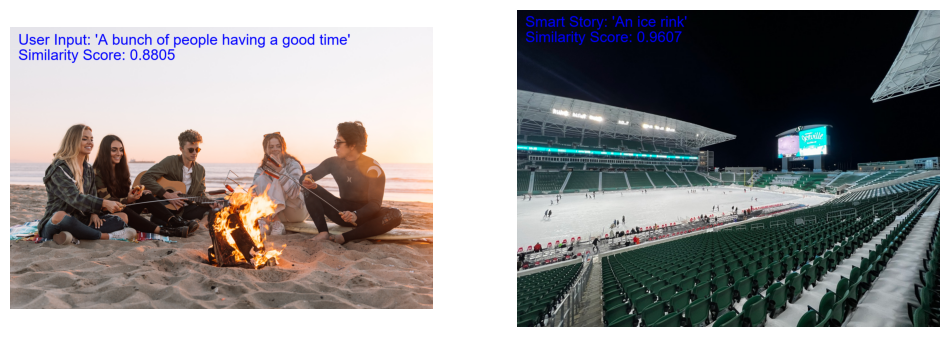

In [15]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

def display_image_with_overlay(image_path, text_source, similarity_score):
    # Load the image
    image = Image.open(image_path)
    
    # Initialize drawing context
    draw = ImageDraw.Draw(image)
    
    # Font settings
    try:
        # Attempt to use a specific font if available
        font = ImageFont.truetype("arial.ttf", 36)
    except IOError:
        # Fallback to default font if specific font is not found
        font = ImageFont.load_default()
        
    # Define the text to overlay
    text = f"{text_source}\nSimilarity Score: {similarity_score:.4f}"
    
    # Position for the text (adjust as needed)
    text_position = (20, 10)

    # Draw text on the image
    draw.text(text_position, text, font=font, fill="blue")
    
    return image

# Defining the image paths
user_input_image_path = f"{BASE_DIR}/exported/{most_similar_image_user}"
smart_story_image_path = f"{BASE_DIR}/exported/{most_similar_image_desc}"

# Display images with overlays
user_input_image = display_image_with_overlay(user_input_image_path, f"User Input: '{user_text_prompt}'", score_user)
smart_story_image = display_image_with_overlay(smart_story_image_path, f"Smart Story: '{smart_story_description}'", score_smart_story)

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(user_input_image)
ax[0].axis('off')  # Hide the axis
ax[1].imshow(smart_story_image)
ax[1].axis('off')  # Hide the axis
plt.show()

In [16]:
def map_similarities_to_images(similarity_scores, image_names):
    """
    Maps each cosine similarity score to its corresponding image name.
    
    Args:
        similarity_scores (numpy.ndarray): An array of cosine similarity scores.
        image_names (list): A list of image names corresponding to the indices of similarity scores.
    
    Returns:
        dict: A dictionary mapping image names to their similarity scores.
    """
    # Flatten the similarity_scores array and convert it to a list
    scores_list = similarity_scores.flatten().tolist()
    
    # Create a dictionary mapping image names to scores
    similarities = dict(zip(image_names, scores_list))
    return similarities


# Match the image name to its similarity with provided text
user_prompt_similarity_mapping = map_similarities_to_images(user_similarity_scores, image_names)
smart_story_description_similarity_mapping = map_similarities_to_images(smart_story_similarity_scores, image_names)

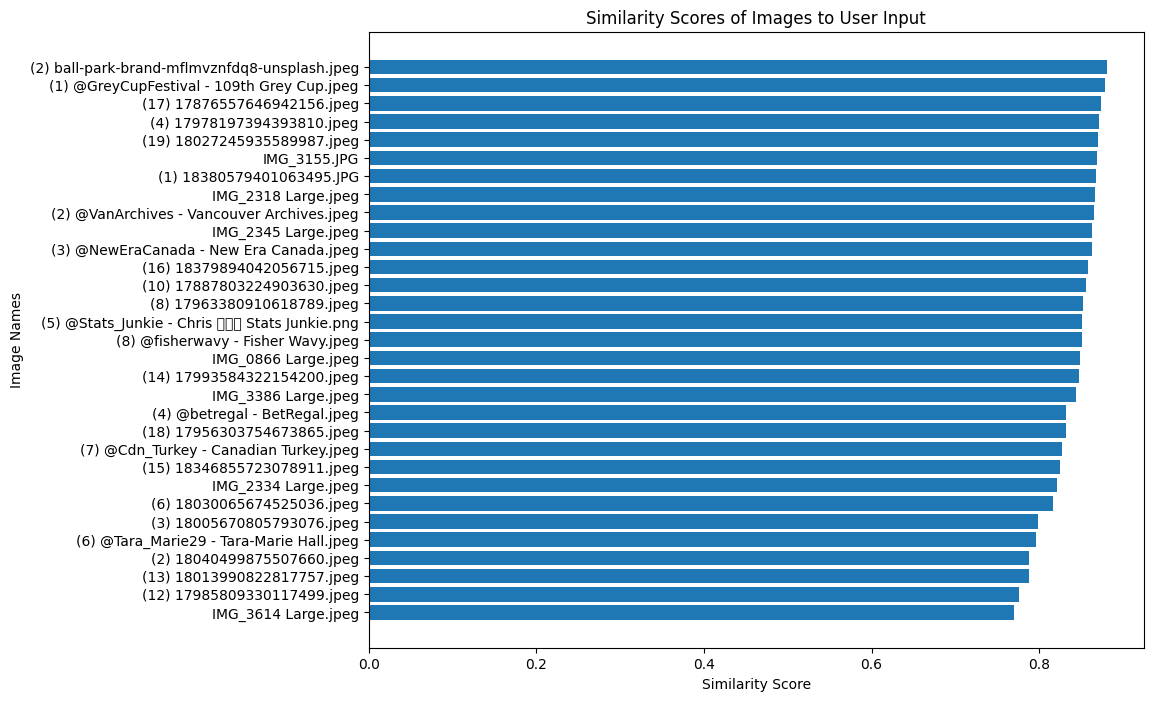

User Input: A bunch of people having a good time


In [17]:
import matplotlib.pyplot as plt

def plot_similarities(similarities, text_name):
    sorted_images = sorted(similarities.items(), key=lambda item: item[1], reverse=True)
    images, scores = zip(*sorted_images)
    
    plt.figure(figsize=(10, 8))
    plt.barh(images, scores)
    plt.xlabel('Similarity Score')
    plt.ylabel('Image Names')
    plt.title(f'Similarity Scores of Images to {text_name}')
    plt.gca().invert_yaxis()  # Ensures higher scores are at the top
    plt.show()

# Here, you would create a mapping of image names to their similarity scores for both user input and smart story,
# For example:
# user_prompt_similarity_mapping = {'image_name_1': 0.95, 'image_name_2': 0.92, ...}
plot_similarities(user_prompt_similarity_mapping, "User Input")
print(f"User Input: {user_text_prompt}")

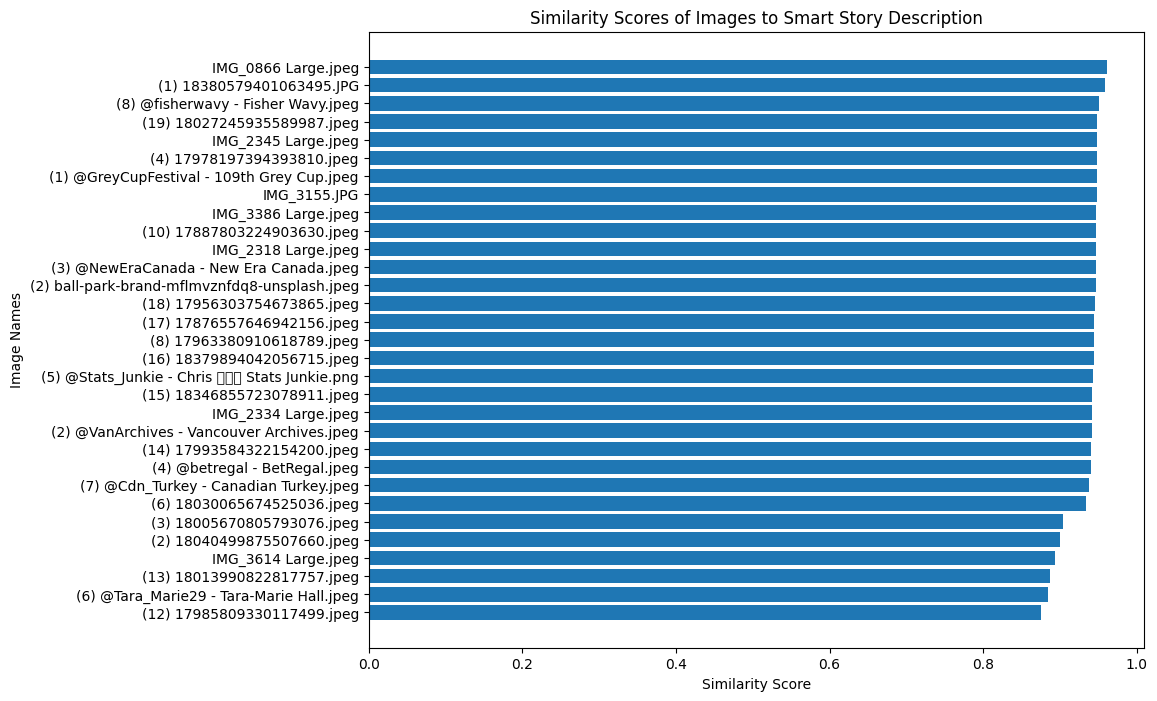

Smart Story Description: An ice rink


In [18]:
plot_similarities(smart_story_description_similarity_mapping, "Smart Story Description")
print("Smart Story Description: " + smart_story_description)